In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import time
import pickle as pickle
import yaml
import emcee

from utils import fitting as ft
from utils import graphics as gp
from utils import read_files as rd
from utils import mm_utilities as ut
from utils import analysis as an
from utils.models import *
from utils.fitting import *

# testing
import numpy as np

In [2]:
#with open('fake_source_ex6zz.fit', 'rb') as input:
with open('fake_source_ex1.fit', 'rb') as input:
    fit_struct = yaml.load(input)
ut.add_filenames(fit_struct)
data_struct = rd.read_data(fit_struct['source_file'], [fit_struct['unit_flux'], fit_struct['unit_obs']])
model_struct = rd.read_mod_file(fit_struct['model_file'])
filter_struct = rd.read_filters(data_struct)

rd.set_init_guess(model_struct)
rd.set_param_start(model_struct)

detection_mask = []
for i in range(len(data_struct)):
    detection_mask.append(data_struct[i]['det_type'] == 'd')


nothing to convert, already in right units


/var/folders/mz/n4w7sm8s1r3096npg5l2k6_w0000gq/T/ipykernel_57759/2956088924.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  fit_struct = yaml.load(input)


In [3]:
def lnprior(theta, models):
#     print(theta.shape, theta)
    tmin = ut.flatten_model_keyword(models, 'min')
    tmax = ut.flatten_model_keyword(models, 'max')
    # trick to get the dimension of table right...
    theta = theta.flatten()

    list_prior = [0.0 if tmin[i] < theta[i] < tmax[i] else -np.inf for i in range(len(tmin))]
#     print(list_prior)
    return sum(list_prior)

def lnprior_un(theta, models):
    # print(theta.shape, theta)
    tmin = ut.flatten_model_keyword(models, 'min')
#     print('tmin',tmin)
#     print('theta',theta)
    # tmax = ut.flatten_model_keyword(models, 'max')
    # trick to get the dimension of table right...
    theta = theta.flatten()
    list_prior=np.zeros(tmin.size)
    list_prior[0] = theta[0]*10.-25.
    list_prior[1] = theta[1]*2.-2.
#     print('list_prior',list_prior)
    return list_prior

def lnprior_un2(theta, models):
    tmin = ut.flatten_model_keyword(models, 'min')
    tmax = ut.flatten_model_keyword(models, 'max')
    theta = theta.flatten()
    list_prior=np.zeros(tmin.size)
#     print('theta',theta)
    for i,elem in enumerate(theta):
#         print(i,elem,tmax[i],tmin[i])
        list_prior[i] = elem*np.abs(tmax[i]-tmin[i])+tmin[i]
#     print('prior',list_prior)
    return list_prior

def lnprob(theta, fit_struct, data, filters, models, detection_mask):
    lp = lnprior(theta, models)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, fit_struct, data, filters, models, detection_mask)

def lnlike(theta, fit_struct, data, filters, param, detection_mask):
    theta = theta.flatten()
    ub = 0
    for i in range(len(param)):
        lb = ub
        ub = param[i]['dim'] + ub
        param[i]['current'] = theta[lb:ub]

    model_data = []
    number_of_component = []
    detections = []
    model_detections = []
    upper_limits = []
    model_upper_limits = []

    for i in range(len(data)):
        number_of_component.append(list(map(int, str.split(data[i]['component_number'][0], ','))))
        min_tmp = np.log10(min(data[i]['lambda0'])*0.01)
        max_tmp = np.log10(max(data[i]['lambda0'])*100.)
        xscale = 10**np.linspace(min_tmp, max_tmp, 2000)
        temp = np.zeros(2000)

        for j in range(len(number_of_component[i])):
#             print(param[number_of_component[i][j]]['current'])
            if fit_struct['redshift'][number_of_component[i][j]] >= 0:
#                 print("pass positive, ", param[number_of_component[i][j]]['func'])
                temp2 = globals()[param[number_of_component[i][j]]['func']]\
                    (xscale, param[number_of_component[i][j]]['current'], fit_struct['redshift'][number_of_component[i][j]])
            else:
                #print "pass negative, ", param[number_of_component[i][j]]['func']
                temp2 = globals()[param[number_of_component[i][j]]['func']]\
                    (xscale, param[number_of_component[i][j]]['current'])
            temp += temp2

        # Making the sum of models to go through filters
        temp_mod_filter = np.empty(data[i]['lambda0'].size)

        for j, elem in enumerate(filters[i]['name']):
            temp_mod_filter[j] = ut.integrate_filter(xscale, temp, filters[i]['wav'][j][:], filters[i]['trans'][j][:])

        model_data.append(temp_mod_filter)


        # splits data in detection or upper limits, since you need to send these ones to different chi2 functions
        detections.append(data[i][detection_mask[i]])
        model_detections.append(model_data[i][np.array(detection_mask[i])])

        upper_limits.append(data[i][~detection_mask[i]])
        model_upper_limits.append(model_data[i][~np.array(detection_mask[i])])


    # calculate the total chi2 which is the main part of this function
    chi2_classic = []
    chi2_modified = []

    for i in range(len(detections)):
        chi2_classic.append(calc_chi2(detections[i]['flux'],
                                      detections[i]['flux_error'],
                                      model_detections[i]))

    for i in range(len(upper_limits)):
        chi2_modified.append(calc_chi2_mod(upper_limits[i]['flux'],
                                           upper_limits[i]['flux_error'],
                                           model_upper_limits[i]))
#     print(chi2_classic,chi2_modified)
    return -(sum(chi2_classic)+sum(chi2_modified))


In [4]:
def wrap_prior(*args):
    return lnprior_un2(*args, model_struct)
def wrap_likelihood(*args):
    return lnlike(*args,fit_struct, data_struct, filter_struct, model_struct, detection_mask)

def meta_decorator(fit_struct, data_struct, filter_struct, model_struct, detection_mask):
    def decorator_list(fnc):
        def inner(*args,**kwargs):
            return fnc(*args, fit_struct, data_struct, filter_struct, model_struct, detection_mask)
        return inner
    return decorator_list

@meta_decorator(fit_struct, data_struct, filter_struct, model_struct, detection_mask)
def like_deco(theta,*args):
    return lnlike(theta,*args)


In [ ]:
# import ultranest
# from functools import partial
# partial?

# param_names=list(ut.flatten_model_keyword(model_struct,'param'))
# theta=np.zeros(2)
# wrap_prior=partial(lnprior_un2,model_struct)
# wrap_like=partial(lnlike,fit_struct, data_struct, filter_struct, model_struct, detection_mask)

# # sampler = ultranest.ReactiveNestedSampler(param_names, deco_likelihood, deco_prior)
# # sampler = ultranest.ReactiveNestedSampler(param_names, lnlike, lnprior_un2)
# # sampler = ultranest.ReactiveNestedSampler(param_names, wrap_like, wrap_prior)


In [ ]:
import ultranest
param_names=list(ut.flatten_model_keyword(model_struct,'param'))
print(param_names)
sampler = ultranest.ReactiveNestedSampler(param_names, like_deco, wrap_prior,resume=True)
start_time=time.time()

In [ ]:
start_time=time.time()
result=sampler.run()
end_time=time.time()
import dill
with open('test.pkl','wb') as file:
    dill.dump(sampler, file)

In [9]:
import ultranest
with open('test.pkl','rb') as file:
    sampler=dill.load(file)
param_names=list(ut.flatten_model_keyword(model_struct,'param'))
# end_time=time.time()
# sampler.plot_corner()
# sampler.plot_run()
# plt.figure()
fig_trace=plt.figure()
ax=ultranest.plot.traceplot(results=sampler.run_sequence, labels=sampler.paramnames + sampler.derivedparamnames)
ultranest.plot.traceplot?
fig_trace.savefig('test.pdf')
# print(end_time-start_time)



AttributeError: module 'ultranest' has no attribute 'plot'

<Figure size 432x288 with 0 Axes>

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       2.51087197e-05, 2.51088276e-05, 2.51092514e-05])

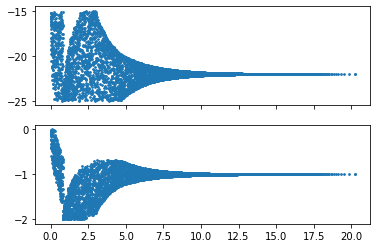

In [35]:
fig, axs = plt.subplots(2, 1,sharex=True)
for i in range(sampler.run_sequence['samples'].shape[1]):
    axs[i].scatter(-sampler.run_sequence['logvol'],sampler.run_sequence['samples'][:,i],s=3)
# plt.scatter(result['samples'][:,1],sampler.run_sequence['logvol'],s=2)
# plt.xscale('log')
sampler.run_sequence.keys()
sampler.run_sequence['weights']

In [66]:
9 % 5

4

In [ ]:
import dill
with open('test.pkl','wb') as file:
    dill.dump(sampler, file)

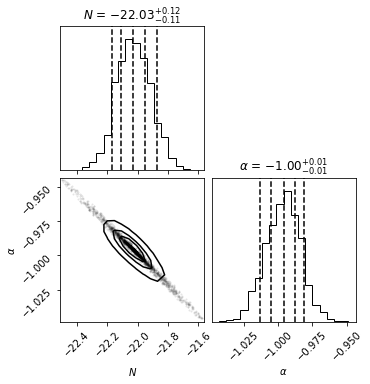

In [11]:
import corner
samples=np.array(sampler.results['weighted_samples']['points'])
weights = np.array(sampler.results['weighted_samples']['weights'])
cumsumweights = np.cumsum(weights)
mask = cumsumweights > 1e-4                   

fig = corner.corner(samples[mask,:], labels=param_names, show_titles=True, verbose=False,
                    quantiles=[0.1,0.25,0.5,0.75,0.9], plot_contours=True, plot_density=False,
                    levels=[0.25,0.5,0.75], fill_contours=False, no_fill_contours=True,
                    smooth=1,weights=weights[mask])

# add the name of the source on top of the corner plot
# fig.text(0.9, 0.9, fit_struct['source'], ha='right')

In [ ]:
result

In [ ]:
from ultranest.plot import PredictionBand
x = 10**np.linspace(7.8, 10., 400)
band = PredictionBand(x)
band_lo = PredictionBand(x)
band_hi = PredictionBand(x)

for params in sampler.results['samples'][:40]:
    y = double_sync_law_z(x,params)
#     slope, offset, scatter = params
#     y = (x - 10) * slope + offset
    band.add(y)

    # indicate intrinsic scatter
#     band_hi.add(10**(y + scatter))
#     band_lo.add(10**(y - scatter))


In [ ]:
plt.plot(data_struct[0]['lambda0'],data_struct[0]['flux'],marker='D',ls='none')
plt.xscale('log');plt.yscale('log')
band.shade(color='k', alpha=0.1)

In [ ]:
sampler.results['samples']

In [ ]:
toto=ut.flatten_model_keyword(model_struct,'param')

In [ ]:
def lnlike(theta, fit_struct, data, filters, param, detection_mask):
    # blablabla
    return chi2

def lnprob(theta, fit_struct, data, filters, models, detection_mask):
    # blablabla
    return lnprior(theta,models) + lnlike(theta, fit_struct, data, filters, models, detection_mask)

def lnprior(theta, models):
    # blablabla
    return prior_list

sampler = emcee.EnsembleSampler(fit_struct['nwalkers'], ndim, lnprob,
                                args=(fit_struct, data_struct, filter_struct, model_struct, detection_mask), backend=backend)


In [ ]:
def wrap_prior(*args):
    return lnprior(*args, model_struct)
def wrap_likelihood(*args):
    return lnlike(*args, fit_struct, data_struct, filter_struct, model_struct, detection_mask)

sampler = ultranest.ReactiveNestedSampler(param_names, wrap_likelihood, wrap_prior)


In [ ]:
ultranest.ReactiveNestedSampler?

In [ ]:
result

In [ ]:
model_struct[0]['bestfit']=result['maximum_likelihood']['point']

In [ ]:
result['maximum_likelihood']['logl']

In [ ]:
import matplotlib as mpl
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt

cmap = mpl.cm.rainbow
fig1 = plt.figure(figsize=(20,20))
ax1 = fig1.add_subplot(111)

dim_plot = 200
min_data = min([min(x['lambda0']) for x in data_struct])*0.1
max_data = max([max(x['lambda0']) for x in data_struct])*10
xscale = 10 ** (np.linspace(np.log10(min_data), np.log10(max_data), dim_plot))

# loop on the arrangement: data and combination of models are the same color
for i_arr in range(len(data_struct)):  # loop on the arrangement
    # get the detection and upper limits from data and plot them
    mask_d = data_struct[i_arr]['det_type'] == 'd'
    mask_ul = data_struct[i_arr]['det_type'] == 'u'

    # get the index of the models from first line of arrangements
    tmp_index_models = list(map(int, str.split(data_struct[i_arr]['component_number'][0], ',')))

    for i_mod in tmp_index_models:  # loop on models in the arrangement
        # defining the parameter index for the randomn selection
        lb = sum([model_struct[i]['dim'] for i in range(i_mod)])
        ub = lb + model_struct[i_mod]['dim']
        tmp_color = cmap(i_mod / float(len(data_struct)))

        # create the line list (segs) and feed in linecollection (improvement of perf for large numbers)
        #dim_prob_full = (fit_struct['nsteps'] - fit_struct['nsteps_cut']) * fit_struct['nwalkers']
        dim_prob = np.arange(len(mask))[mask].size
        segs = np.zeros((dim_prob, dim_plot, 2))

        for cpt_s,i_steps in enumerate(np.arange(len(mask))[mask]):
            y_spa = globals()[model_struct[i_mod]['func']]\
                (xscale, result['weighted_samples']['points'][mask, lb:ub][cpt_s], fit_struct['redshift'][i_mod])
#             segs[(cpt_s*np.arange(len(mask))[mask].size), :, 1] = y_spa
            segs[cpt_s, :, 1] = y_spa
            
        segs[:, :, 0] = xscale
        lines = LineCollection(segs, colors=tmp_color, lw=0.1, alpha=0.1)
        ax1.add_collection(lines)

        y_bestfit = globals()[model_struct[i_mod]['func']]\
            (xscale, model_struct[i_mod]['bestfit'], fit_struct['redshift'][i_mod])
        ax1.plot(xscale, y_bestfit, color='k', ls='-')

    ax1.errorbar(filter_struct[i_arr]['center'][mask_d],
                data_struct[i_arr]['flux'][mask_d],
                xerr=filter_struct[i_arr]['FWHM'][mask_d],
                yerr=data_struct[i_arr]['flux_error'][mask_d],
                ls='None', color='k', marker='D')
    ax1.plot(filter_struct[i_arr]['center'][mask_ul],
            data_struct[i_arr]['flux'][mask_ul],
            ls='None', color='k', marker='v')

# setting plot axes, labels, etc
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("Frequency [Hz]")
ax1.set_ylabel(r"F$_\nu}$ [erg s$^{-1}$ cm$^{-2}$ Hz$^{-1}$]")
ax1.set_xlim(min([min(x['lambda0']) for x in data_struct]) * 0.1,
             max([max(x['lambda0']) for x in data_struct]) * 10.)
ax1.set_ylim(min([min(x['flux']) for x in data_struct]) * 0.1,
             max([max(x['flux']) for x in data_struct]) * 10.)
ax1.annotate(fit_struct['source'], xy=(0.9, 0.9), xycoords='axes fraction', horizontalalignment='right')


In [ ]:
model_struct[0]['bestfit']

In [ ]:
result['weighted_samples']['points'].shape

In [ ]:
result['weighted_samples']['points']